<a href="https://colab.research.google.com/github/SIMMAVONG/SIMMAVONG/blob/main/predicting_student_performance_in_mathematics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Student Performance in Mathematics

The obejctive of this project is to build and compare three binary classifiers for predicting student performance in Mathematics, using the data collected from two public schools in Portugal during the school year 2005/06. The dataset was retrieved from the UCI Machine
Learning Repository (Cortez & Silva, 2008). The descriptive features include 5 numeric, 17 nominal and 10 ordinal features.
The target feature, G3, is a numeric variable, which shows the final grade. The values of G3 range from 0 to 20, where 0 represents the lowest grade while 20 represents full marks. For a binary classification, G3 values that are greater or equal to 10 represent "Pass", else "Fail".

## Outline:
- [Section 1 (Overview)](#1)
- [Section 2 (Data Preparation)](#2)  
- [Section 3 (Hyperparameter Tuning)](#3)
- [Section 4 (Performance Comparison)](#4)
- [Section 5 (Summary)](#5)
- [Section 6 (References)](#6)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Overview <a class="anchor" id="1"></a>

## Methodology

I build three classification models, K-Nearest Neighbors (KNN), Decision Trees (DT) and Naive Bayes (NB), to predict whether students pass or fail in Mathematics.

I start by transforming the dataset. The categorical features are encoded into numerical features and the whole descriptive features are scaled using Min-Max Scaling. The dataset is then partitioned into two parts at a 70:30 ratio for training and test.

Then, given the large number of columns of descriptive features after transformation, applying feature selection could be beneficial before fitting the model. I select the top 10 features by Random Forest Importance and F-Score. Then, I compare the performance of these two feature selection methods and continue with the better one for further model fitting.

After the feature selection, I train the models with hyperparameter search in a pipeline with 5-fold repeated stratified cross-validation based on the train data with full features and the same train data but only with the top 10 features selected in the previous stage.

Stratification is necessary throughout the model fitting and selection as the binary target classes are imbalanced.

In the end, I fit the best models identified from the hyperparameter search on the test data with a 5-fold repeated stratified cross-validation and compare the model performance by a paired t-test to determine if these models yield any significant differences. The comparison is initially based on the metric area under curve (AUC), and I integrate other evaluation metrics, such as recall, precision, and F1-score, for a comprehensive and in-depth comparison.

# Data Preparation <a class="anchor" id="2"></a>

## Loading Dataset

In [14]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
np.random.seed(999)

In [15]:
math = pd.read_csv('/content/drive/MyDrive/Dr Lathsamy-CS-FNS/Projects 2 7 23/student-mat (2).csv')
math.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,target
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,fail
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,fail
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,pass
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,pass
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,pass


In [16]:
print(math.shape)
math.columns.values

(395, 34)


array(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
       'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
       'studytime', 'failures', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'romantic',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences', 'G1', 'G2', 'G3', 'target'], dtype=object)

The dataset contains 395 observations. The numeric target feature "G3" has been renamed as "target" and transformed into a binary categorical feature with two levels "pass" and "fail".

## Checking for Missing Values

In [17]:
math.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
target        0
dtype: int64

## Summary Statistics

In [18]:
math.describe(include='all')

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,target
count,395,395,395.000000,395,395,395,395.000000,395.000000,395,395,...,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395
unique,2,2,NaN,2,2,2,NaN,NaN,5,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,GP,F,NaN,U,GT3,T,NaN,NaN,other,other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass
freq,349,208,NaN,307,281,354,NaN,NaN,141,217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310
mean,NaN,NaN,16.696203,NaN,NaN,NaN,2.749367,2.521519,NaN,NaN,...,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190,NaN
std,NaN,NaN,1.276043,NaN,NaN,NaN,1.094735,1.088201,NaN,NaN,...,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443,NaN
min,NaN,NaN,15.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,NaN
25%,NaN,NaN,16.000000,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,...,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000,NaN
50%,NaN,NaN,17.000000,NaN,NaN,NaN,3.000000,2.000000,NaN,NaN,...,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000,NaN
75%,NaN,NaN,18.000000,NaN,NaN,NaN,4.000000,3.000000,NaN,NaN,...,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000,NaN


## Encoding Categorical Features

It is necessary to encode all categorical features into numerical features, since Scikit-learn requires all data to be numeric before putting them into the algorithm.

Before encoding the target feature, the descriptive features and the target feature need to be partitioned.

In [19]:
data = math.drop(columns ='target')
target = math['target']

### Target Feature

It is obvious that the target classes are imbalanced. The number of "pass" is twice as many as that of "fail".

The positive target feature level "pass" is encoded as "1".

In [20]:
print(target.value_counts())
target = target.replace({'pass':1,'fail':0})
target.value_counts()

pass    310
fail     85
Name: target, dtype: int64


1    310
0     85
Name: target, dtype: int64

### Categorical Descriptive Features

There are two types of categorical descriptive features in the dataset.

#### Nominal:

13 out of the 17 nominal features have only two levels, therefore they are simply encoded into a single column of 0 and 1. The remaining 4 features have more than two levels, therefore applying one-hot-encoding is necessary as it can create a binary column for each unique value under these multi-level nominal features.

1. sex: binary - female or male)
2. school: binary - Gabriel Pereira or Mousinho da Silveira
3. address: binary - urban or rural
4. Pstatus: binary - living together or apart
5. Mjob: 5 levels
6. Fjob: 5 levels
7. guardian: 3 levels
8. famsize: binary - ≤ 3 or > 3
9. reason: 4 levels
10. schoolsup: binary - yes or no
11.	famsup: binary - yes or no
12.	activities: binary - yes or no
13.	paidclass: binary - yes or no
14.	internet: binary - yes or no
15.	nursey: binary - yes or no
16.	higher: binary - yes or no
17.	romantic: binary - yes or no

In [21]:
nominal_cols = data.columns[data.dtypes==object].tolist()
nominal_cols

['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

Ordinal:
The ordinal categorical features have been encoded into numbers in the original dataset and therefore there is no need to further transform them. The numbers under each ordinal categorical feature are meaningful. For example, under the feature "Medu" (mother's education level), 0 is "none"; 1 is "primary education"; 2 is "5th to 9th grade"; 3 is "secondary education"; 4 is "higher education". The larger the number, the higher the education level.

1. Medu: 0 to 4; the larger the number, the higher the education level
2. Fedu: 0 to 4; the larger the number, the higher the education level
3. famrel: 1 to 5; the larger the number, the higher the quality of family relationship
4. traveltime: 1 to 4; the larger the number, the longer the travel time to school
5. studytime: 1 to 4; the larger the number, the longer the weekly study time
6. freetime: 1 to 5; the larger the number, the more free time after school
7. goout: 1 to 5; the larger the number, the more frequent going out with friends
8. Walc: 1 to 5; the larger the number, the more weekend alcohol consumption
9. Dalc: 1 to 5; the larger the number, the more workday alcohol consumption
10. health: 1 to 5; the larger the number, the healthier

In [22]:
for col in nominal_cols:
    n = len(data[col].unique())
    if (n == 2):
        data[col] = pd.get_dummies(data[col], drop_first=True)

In [26]:
data = pd.get_dummies(data)
data = pd.get_dummies(data)

After performing one-hot-enconding on those 4 nominal features, the number of columns with descriptive features in the dataset extend from 32 to 45.

## Feature Scaling

Scaling descriptive features is beneficial as it can normalise the numeric values among different variables within a specific range and can help speed up the processing time in the algorithm.
Min-Max Scaling is applied to scale the descriptive features between 0 and 1. Each binary feature can be still kept as binary after scaling.

In [27]:
from sklearn import preprocessing
data_unscaled=data.values
data_scaled = preprocessing.MinMaxScaler().fit_transform(data_unscaled)

In [28]:
pd.DataFrame(data_scaled, columns=data.columns).head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0.0,0.0,0.428571,1.0,0.0,0.0,1.00,1.00,0.333333,0.333333,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.285714,1.0,0.0,1.0,0.25,0.25,0.000000,0.333333,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.000000,1.0,1.0,1.0,0.25,0.25,0.000000,0.333333,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.000000,1.0,0.0,1.0,1.00,0.50,0.000000,0.666667,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.142857,1.0,0.0,1.0,0.75,0.75,0.000000,0.333333,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Feature Selection & Ranking

The 1-nearest neighbor classifier is used as a wrapper to compare the performance of feature selection methods: F-Score and Random Forest Importance. I also use stratified 5-fold cross validation with 3 repetitions for assessment.

In [29]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=1)
cv_method = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,random_state=999)

### Full Set of Features
Before applying the feature selection methods, I assess the perfomance using all descriptive features in the dataset.

In [30]:
from sklearn.model_selection import cross_val_score
cv_results_full = cross_val_score(estimator=clf,
                             X=data_scaled,
                             y=target,
                             cv=cv_method,
                             scoring='roc_auc')
cv_results_full.mean()

0.6139152435167615

The AUC score for the full features is very low, at 0.556. There are probably some irrelevant features in the dataset that weaken the performance of the model.

### Random Forest Importance

In [31]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(999)
model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(data_scaled, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:10]

best_features_rfi = data.columns[fs_indices_rfi].values
print(best_features_rfi)

feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
print(feature_importances_rfi)

['G2' 'G3' 'G1' 'failures' 'absences' 'age' 'Medu' 'goout' 'health'
 'freetime']
[0.3093589  0.22688177 0.15650237 0.04836385 0.02774562 0.01557019
 0.01383451 0.01260508 0.01187734 0.01167762]


In [32]:
cv_results_rfi = cross_val_score(estimator=clf,
                             X=data_scaled[:, fs_indices_rfi],
                             y=target,
                             cv=cv_method,
                             scoring='roc_auc')
cv_results_rfi.mean()

0.8030676786843769

The AUC score for the top 10 features selected by Random Forest Importance is 0.753.

### F-Score

In [33]:
from sklearn import feature_selection as fs
np.random.seed(999)
fs_fit_fscore = fs.SelectKBest(fs.f_classif, k=10)
fs_fit_fscore.fit_transform(data_scaled, target)
fs_indices_fscore = np.argsort(fs_fit_fscore.scores_)[::-1][0:10]
best_features_fscore = data.columns[fs_indices_fscore].values
print(best_features_fscore)
feature_importances_fscore = fs_fit_fscore.scores_[fs_indices_fscore]
print(feature_importances_fscore)

['G3' 'G2' 'G1' 'failures' 'higher' 'Medu' 'paid' 'Fedu' 'Mjob_teacher'
 'studytime']
[470.59742453 360.09980815 237.47390752  72.55640686  19.2795586
   9.809394     6.03846981   5.82955409   5.06518855   4.8436773 ]


In [34]:
cv_results_fscore = cross_val_score(estimator=clf,
                             X=data_scaled[:, fs_indices_fscore],
                             y=target,
                             cv=cv_method,
                             scoring='roc_auc')
cv_results_fscore.mean()

0.8481973434535103

The AUC score for the top 10 features selected by F-Score is 0.812.

### Performance Comparison Using Paired T-Tests

In [35]:
from scipy import stats
print(stats.ttest_rel(cv_results_full, cv_results_fscore).pvalue.round(3))
print(stats.ttest_rel(cv_results_full, cv_results_rfi).pvalue.round(3))
print(stats.ttest_rel(cv_results_rfi, cv_results_fscore).pvalue.round(3))

0.0
0.0
0.028


The performances after feature selection by both Random Forest Importance and F-Score are statistically better than the performance based on the full features, at 5% level of significance.
Meanwhile, the difference between F-Score and Random Forest Importance is also statistically significant. Therefore, for the further analysis, I continue with the top 10 features selected by F-Score as shown in the below figure. In this figure, it shows that the importance decreases sharply after the top 2 features. The importance becomes very marginalised till the last feature.

<Axes: xlabel='Feature', ylabel='Importance'>

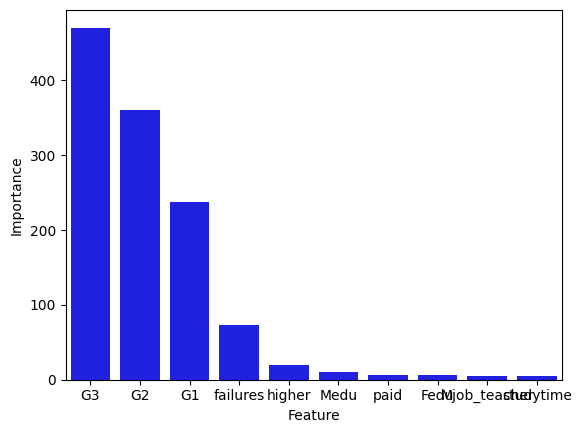

In [36]:
feature_ranking = pd.DataFrame({'Feature': best_features_fscore,
                                'Importance': list(feature_importances_fscore)},
                               columns=['Feature', 'Importance'])
import seaborn as sns
sns. barplot(x="Feature",y="Importance",
            color='blue',data=feature_ranking)

## Train-Test Splitting

The dataset is split into train and test at a 70:30 partition ratio by stratification:

* Training (70%): X_train (descriptive), y_train (target)
* Testing (30%): X_test (desciptive), y_test (target)

Meanwhile, I created X_train_10 and X_test_10, which have the same sample rows as X_train and X_test, but only have the top 10 features selected by F-score from the previous process.

In [37]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data_scaled,
                                                 target.values,
                                                 test_size=0.3,
                                                 random_state=999,
                                                 stratify=target.values)
print(X_train.shape)
print(X_test.shape)

(276, 46)
(119, 46)


In [38]:
X_train_10 = pd.DataFrame(X_train, columns=data.columns)
X_train_10 = X_train_10[best_features_fscore].values
X_test_10 = pd.DataFrame(X_test, columns=data.columns)
X_test_10 = X_test_10[best_features_fscore].values
print(X_train_10.shape)
print(X_test_10.shape)

(276, 10)
(119, 10)


# Hyperparameter Tuning<a class="anchor" id="3"></a>

In this section, I train and fine-tune the models based on the 276 rows of training data. I also compare the performance of models with the full features and with the top 10 features.

Each model is evaluated by 5-fold stratified cross-validation with 3 repetitions for hyperparameter tuning.

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
cv_method = RepeatedStratifiedKFold(n_splits = 5,n_repeats=3,random_state=999)

## 1. K-Nearest Neighbors

I use grid search for hyperparameter tuning in a pipeline and train the KNN model with different k-nearest neighbors and distance types.

In [40]:
params_knn = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
              'p': [1, 2]}
gs_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                      param_grid=params_knn,
                      cv=cv_method,
                      verbose=1,
                      scoring='roc_auc')

In [41]:
gs_knn.fit(X_train, y_train)
print(gs_knn.best_params_)
print(gs_knn.best_score_)
knn_best = gs_knn.best_estimator_
print(knn_best)

Fitting 15 folds for each of 28 candidates, totalling 420 fits
{'n_neighbors': 15, 'p': 1}
0.8436663143058493
KNeighborsClassifier(n_neighbors=15, p=1)


In [42]:
gs_knn.fit(X_train_10, y_train)
print(gs_knn.best_params_)
print(gs_knn.best_score_)
knn_best10 = gs_knn.best_estimator_
print(knn_best10)

Fitting 15 folds for each of 28 candidates, totalling 420 fits
{'n_neighbors': 15, 'p': 1}
0.9805667670361117
KNeighborsClassifier(n_neighbors=15, p=1)


* The optimal KNN model based on the full features has a mean AUC score of 0.725 with 14 nearest neighbors and with Manhattan distance.
* The optimal KNN model based on the top 10 features has a mean AUC score of 0.934 with 14 nearest neighbors and with Manhattan distance.

In general, the performance of KNN models seems to have improved after feature selection.

## 2. Decision Tree

To find the optimal Decision Tree model, I include different criterion (gini index and entropy), maximum depth and minimum sample split in the grid search.

In [43]:
from sklearn.tree import DecisionTreeClassifier
params_dt = {'criterion':['gini','entropy'],
             'max_depth':[3,4,5,6,7,8,9,10],
             'min_samples_split':[2,3,4,5]}

gs_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=999),
                      param_grid=params_dt,
                      cv=cv_method,
                      verbose=1,
                      scoring='roc_auc')

In [44]:
gs_dt.fit(X_train, y_train)
print(gs_dt.best_params_)
print(gs_dt.best_score_)
dt_best = gs_dt.best_estimator_
print(dt_best)

Fitting 15 folds for each of 64 candidates, totalling 960 fits
{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
0.9478836995750314
DecisionTreeClassifier(max_depth=3, random_state=999)


In [45]:
gs_dt.fit(X_train_10, y_train)
print(gs_dt.best_params_)
print(gs_dt.best_score_)
dt_best10 = gs_dt.best_estimator_
print(dt_best10)

Fitting 15 folds for each of 64 candidates, totalling 960 fits
{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 5}
0.9697499572895978
DecisionTreeClassifier(max_depth=4, min_samples_split=5, random_state=999)


The optimal Decision Tree model based on the full features has a mean AUC score of 0.956 using gini index. It has a maximum depth of 3 and minimum split value of 2 samples.
The optimal Decision Tree model based on the top 10 features has a mean AUC score of 0.963 using entropy. It also has a maximum depth of 3 and minimum split value of 2 samples.
It seems the performance of KNN models does not improve much after feature selection, but I will confirm it with a paired t-tests later.

## 3. (Gaussian) Naive Bayes

I include different var_smoothing to search for the optimal Gaussian Naive Bayes model, starting with 1 to 10^-9 with 100 different values. Before fitting into the algorithm, I perform a power transformation to ensure that each descriptive feature follows a Gaussian distribution.

In [46]:
from sklearn.preprocessing import PowerTransformer
X_train_trans = PowerTransformer().fit_transform(X_train)
X_train_10_trans = PowerTransformer().fit_transform(X_train_10)

In [47]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(999)
params_nb ={'var_smoothing': np.logspace(0,-9,num=100)}
gs_nb =GridSearchCV(estimator=GaussianNB(),
                   param_grid=params_nb,
                   cv=cv_method,
                   verbose=1,
                   scoring='roc_auc')

In [48]:
gs_nb.fit(X_train_trans, y_train)
print(gs_nb.best_params_)
print(gs_nb.best_score_)
nb_best = gs_nb.best_estimator_
print(nb_best)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
{'var_smoothing': 1.0}
0.9337558993742927
GaussianNB(var_smoothing=1.0)


In [49]:
gs_nb.fit(X_train_10_trans, y_train)
print(gs_nb.best_params_)
print(gs_nb.best_score_)
nb_best10 = gs_nb.best_estimator_
print(nb_best10)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
{'var_smoothing': 0.005336699231206307}
0.9715025519465266
GaussianNB(var_smoothing=0.005336699231206307)


The optimal Naive Bayes model based on the full features yields a meal AUC score of 0.889, while the optimal one based on the top 10 features has a mean AUC score of 0.931.

# Performance Comparison <a class="anchor" id="4"></a>

In this section, I fit the optimal models from the above analyses on the test data with 5-fold stratified cross validation and 3 repetitions. Then, I compare the performance of models by paired t-test:
* DT (full features) vs. DT (top 10 features)
* KNN (full features) vs. KNN (top 10 features)
* NB (full features) vs. NB (top 10 features)

Full Features:
* DT vs. KNN
* DT vs. NB
* KNN vs. NB

Top 10 Features:
* DT vs. KNN
* DT vs. NB
* KNN vs. NB

In [50]:
from sklearn.model_selection import cross_val_score

cv_method_ttest = RepeatedStratifiedKFold(n_splits=5,n_repeats=3,
                                          random_state=999)

In [51]:
cv_results_knn = cross_val_score(estimator=knn_best,
                                 X=X_test,
                                 y=y_test,
                                 cv=cv_method_ttest,
                                 scoring='roc_auc')
cv_results_knn_10 = cross_val_score(estimator=knn_best10,
                                 X=X_test_10,
                                 y=y_test,
                                 cv=cv_method_ttest,
                                 scoring='roc_auc')
cv_results_dt = cross_val_score(estimator=dt_best,
                                X=X_test,
                                y=y_test,
                                cv=cv_method_ttest,
                                scoring='roc_auc')
cv_results_dt_10 = cross_val_score(estimator=dt_best10,
                                X=X_test_10,
                                y=y_test,
                                cv=cv_method_ttest,
                                scoring='roc_auc')
cv_results_nb = cross_val_score(estimator=nb_best,
                                X=X_test,
                                y=y_test,
                                cv=cv_method_ttest,
                                scoring='roc_auc')
cv_results_nb_10 = cross_val_score(estimator=nb_best10,
                                X=X_test_10,
                                y=y_test,
                                cv=cv_method_ttest,
                                scoring='roc_auc')
print("KNN(full features):",cv_results_knn.mean())
print("KNN(top 10 features):",cv_results_knn_10.mean())
print("DT(full features):",cv_results_dt.mean())
print("DT(top 10 features):",cv_results_dt_10.mean())
print("NB(full features):",cv_results_nb.mean())
print("NB(top 10 features):",cv_results_nb_10.mean())

KNN(full features): 0.7958609486679663
KNN(top 10 features): 0.9444704353476283
DT(full features): 0.9229434697855751
DT(top 10 features): 0.9252339181286547
NB(full features): 0.7730734243014943
NB(top 10 features): 0.9242560103963613


In [52]:
print(stats.ttest_rel(cv_results_dt, cv_results_dt_10))
print(stats.ttest_rel(cv_results_nb, cv_results_nb_10))
print(stats.ttest_rel(cv_results_knn, cv_results_knn_10))

TtestResult(statistic=-0.1607322489531722, pvalue=0.8746005546493669, df=14)
TtestResult(statistic=-5.747337018652032, pvalue=5.0478115802444565e-05, df=14)
TtestResult(statistic=-5.976196838527565, pvalue=3.39087450620161e-05, df=14)


The above results show that all models perform significantly better with the top 10 features selected by F-Score, than with the full features, at a 5% level of significance.

In [53]:
print(stats.ttest_rel(cv_results_dt, cv_results_knn))
print(stats.ttest_rel(cv_results_dt, cv_results_nb))
print(stats.ttest_rel(cv_results_knn, cv_results_nb))

TtestResult(statistic=6.50321325328784, pvalue=1.3944130919097455e-05, df=14)
TtestResult(statistic=5.755615277005932, pvalue=4.9750574518334256e-05, df=14)
TtestResult(statistic=1.1295502651603704, pvalue=0.27764840286244596, df=14)


For models based on the full features, the Decision Tree model performs significantly better than KNN and Naive Bayes models, at a 5% level of significance. KNN and Naive Bayes models perform at similar levels.

In [54]:
print(stats.ttest_rel(cv_results_dt_10, cv_results_knn_10))
print(stats.ttest_rel(cv_results_dt_10, cv_results_nb_10))
print(stats.ttest_rel(cv_results_knn_10, cv_results_nb_10))

TtestResult(statistic=-0.8745713931229808, pvalue=0.3965627967926201, df=14)
TtestResult(statistic=0.03735372282084963, pvalue=0.9707303820044317, df=14)
TtestResult(statistic=1.7506768905688892, pvalue=0.10187280370479893, df=14)


For models based on the top 10 features selected by F-Score, the KNN model performs significantly better than the Naive Bayes model. Decision Tree performs similarily comparing with either KNN or Naive Bayes models. It is hard to decide the optimal model at this stage with only AUC score available, but based on the above performance comparison, it is clear that all models with the top 10 features perform better on the test data. Therefore, for further evaluation on accuracy, precision, recall, F1 Score and confusion matrix, I only consider models with the top 10 features.

In [55]:
pred_knn = gs_knn.predict(X_test_10)
pred_dt = gs_dt.predict(X_test_10)
X_test_10_trans = PowerTransformer().fit_transform(X_test_10)
pred_nb = gs_nb.predict(X_test_10_trans)

In [56]:
from sklearn import metrics
print("\nKNN: Confusion matrix")
print(metrics.confusion_matrix(y_test, pred_knn))
print("\nKNN: Classification report")
print(metrics.classification_report(y_test, pred_knn))

print("\nDT: Confusion matrix")
print(metrics.confusion_matrix(y_test, pred_dt))
print("\nDT: Classification report")
print(metrics.classification_report(y_test, pred_dt))

print("\nNB: Confusion matrix")
print(metrics.confusion_matrix(y_test, pred_nb))
print("\nNB: Classification report")
print(metrics.classification_report(y_test, pred_nb))


KNN: Confusion matrix
[[11 15]
 [ 0 93]]

KNN: Classification report
              precision    recall  f1-score   support

           0       1.00      0.42      0.59        26
           1       0.86      1.00      0.93        93

    accuracy                           0.87       119
   macro avg       0.93      0.71      0.76       119
weighted avg       0.89      0.87      0.85       119


DT: Confusion matrix
[[23  3]
 [ 3 90]]

DT: Classification report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        26
           1       0.97      0.97      0.97        93

    accuracy                           0.95       119
   macro avg       0.93      0.93      0.93       119
weighted avg       0.95      0.95      0.95       119


NB: Confusion matrix
[[23  3]
 [ 7 86]]

NB: Classification report
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        26
           1       0.97      0.

Suppose the school wants to predict students who are likely to fail the Mathematics course in order to give these students more support in advance. Then the recall of "0" (fail) is an important metric to consider in this case. The Decision Tree model is the most optimal one.
However, if the school wants to correctly predict students who are likely to pass in order to select good students to attend Mathematics competitions, the recall of "1" (pass) should be emphasized. Therefore, the KNN model can be the most optimal one.
In general, the Decision Tree model can be regarded as the best model in terms of the F1-score as this score is a weighted harmonic mean of precision and recall.

# Summary <a class="anchor" id="5"></a>

The Decision Tree model based on the top 10 features selected by F-Score is the best model for prediction in this analysis, under a limited hyperparameter tuning and feature selection approach. Although there is not enough statiscal evidence to show that this Descision Tree model performs better than the other KNN and Naive Bayes models, at a 5% level of significance, it yields the highest AUC score (0.916) and F1 score (0.9). In general, all models with only the top 10 features selected by F-Score perform significantly better than those with the full features, at a 5% level of significance.

# References <a class="anchor" id="6"></a>
* P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.